In [22]:
import numpy as np
import matplotlib.pyplot as plt
import scipy 
from sklearn.model_selection import ParameterGrid
from sklearn.manifold import Isomap
import time
from tqdm import tqdm

import librosa
from librosa import cqt
from librosa.core import amplitude_to_db
from librosa.display import specshow

import os
import glob

In [23]:
data_dir= '/Users/sripathisridhar/googleDrive/projects/helix/helix2019_data/SOL'

## Data management

In [3]:
file_paths= sorted(glob.glob(os.path.join(data_dir, '**', '*.wav')))

file_names= []
for file_path in file_paths:
    file_names.append(os.path.basename(file_path))

## Feature extraction

In [4]:
hop_size= 512
q= 24

In [5]:
features_dict= {}
feature_key= ''

for file_path in tqdm(file_paths, disable=False):

    # Read audio files
    waveform, sample_rate= librosa.load(file_path, sr=None)

    # Compute CQTs
    cqt_complex= cqt(y=waveform,
                    sr=sample_rate,
                    hop_length=hop_size,
                    bins_per_octave=q,
                    n_bins=q*7,
                    sparsity=1e-6,
                    )
    scalogram= np.abs(cqt_complex)**2

    # Find frame with maximum RMS value
    rms= librosa.feature.rms(y=waveform,
                              hop_length=hop_size,
                             )
    rms_argmax= np.argmax(rms)
    feature= scalogram[:,rms_argmax]

    # Stack in dict
    file_name= os.path.basename(file_path)
    feature_key= f'{file_name}'
    features_dict[feature_key]= feature

100%|██████████| 1212/1212 [05:09<00:00,  4.37it/s]


with h5py.File('fig2_SOL_temp.h5', 'w') as h5_file:
    for key in features_dict.keys():
        h5_file[key] = features_dict[key]

## Settings list

In [8]:
grid = {
    'Q': [24],
    'k': [3],
    'comp': ['log'],
    'instr': ['all'],
    'dyn': ['all']
}

settings = list(ParameterGrid(grid))

for setting in settings:
    
    if setting["instr"] == 'all':
        setting['instr'] = ''
    
    if setting['dyn'] == 'all':
        setting['dyn'] = ''

## Isomap embedding

In [17]:
batch_str = []
CQT_OCTAVES = 7

features_keys = list(features_dict.keys())

for setting in settings:
    
    q = setting['Q']
    # Batch process and store in a folder
    batch_str = [setting['instr'], setting['dyn']]

    batch_features = []
    for feature_key in features_keys:
        # Get features that match setting
        
        if all(x in feature_key for x in batch_str):
            batch_features.append(features_dict[feature_key])
    
    batch_features = np.stack(batch_features, axis=1)
    
    # Isomap parameters
    hop_size = 512
    compression = 'log'
    features = amplitude_to_db(batch_features)
    n_neighbors = setting['k']
    n_dimensions = 3
    n_octaves = 3    

    # Prune feature matrix
    bin_low = np.where((np.std(features, axis=1) / np.std(features)) > 0.1)[0][0] + q
    bin_high = bin_low + n_octaves*q 
    X = features[bin_low:bin_high, :]

    # Z-score Standardization- improves contrast in correlation matrix
    mus = np.mean(X, axis=1)
    sigmas = np.std(X, axis=1)
    X_std = (X - mus[:, np.newaxis]) / (1e-6 + sigmas[:, np.newaxis]) # 1e-6 to avoid runtime division by zero

    # Pearson correlation matrix
    rho_std = np.dot(X_std, X_std.T) / X_std.shape[1]
    
    # Isomap embedding
    isomap = Isomap(n_components= n_dimensions, n_neighbors= n_neighbors)
    coords = isomap.fit_transform(rho_std)
    
    # Get note value
    freqs= librosa.cqt_frequencies(q*CQT_OCTAVES, fmin=librosa.note_to_hz('C1'), bins_per_octave=q) #librosa CQT default fmin is C1
    chroma_list= librosa.core.hz_to_note(freqs[bin_low:bin_high])
    
    notes = []
    reps = q//12
    for chroma in chroma_list:
        for i in range(reps):
            notes.append(chroma)
 

100%|██████████| 1/1 [00:00<00:00, 60.87it/s]


## Isomap and Pearson correlation matrix

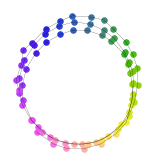

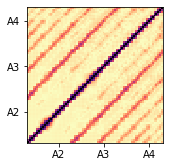

In [36]:
curr_fig= plt.figure(figsize=(5.5, 2.75))
ax= curr_fig.add_subplot(121)
ax.axis('off')

import colorcet as cc
subsampled_color_ids = np.floor(np.linspace(0, 256, q, endpoint=False)).astype('int')
color_list= [cc.cyclic_mygbm_30_95_c78[i] for i in subsampled_color_ids]

# Plot embedding with color
for i in range(coords.shape[0]):
    plt.scatter(coords[i, 0], coords[i, 1], color= color_list[i%q], s=30.0)

plt.plot(coords[:, 0], coords[:, 1], color='black', linewidth=0.2)

# Plot Pearson correlation matrix
rho_frequencies = freqs[bin_low:bin_high]

freq_ticklabels = ['A2', 'A3', 'A4']
freq_ticks = librosa.core.note_to_hz(freq_ticklabels)

tick_bins = []
tick_labels= []
for i,freq_tick in enumerate(freq_ticks):
    tick_bin = np.argmin(np.abs(rho_frequencies-freq_tick))
    tick_bins.append(tick_bin)
    tick_labels.append(freq_ticklabels[i])

plt.figure(figsize=(2.5,2.5))
plt.imshow(np.abs(rho_std), cmap='magma_r')
plt.xticks(tick_bins)
plt.gca().set_xticklabels(freq_ticklabels)
# plt.xlabel('Log-frequency (octaves)')
plt.yticks(tick_bins)
plt.gca().set_yticklabels(freq_ticklabels)
# plt.ylabel('Log-frequency (octaves)')
plt.gca().invert_yaxis()

plt.clim(0, 1)


## Shortest path distance matrix

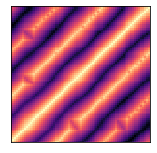

In [37]:
kng = isomap.nbrs_.kneighbors_graph
A = kng().toarray()

plt.figure(figsize=(2.5,2.5))
specshow(isomap.dist_matrix_, cmap='magma_r')

### Trumpet scalogram

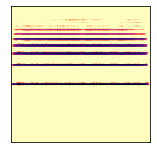

In [40]:
wav_name= 'TpC-ord-C4-pp.wav'
tpc_dir= 'TpC-ord'
wav_path= os.path.join(data_dir, tpc_dir, wav_name)

wav_raw, sr= librosa.core.load(wav_path, sr=None)
# wav_trim,_= librosa.effects.trim(y=wav_raw)
wav_trim= np.roll(wav_raw, shift=0)

# Compute spectrogram

scalogram= librosa.core.cqt(y=wav_trim, 
                            bins_per_octave=24, 
                            hop_length=512, 
                            n_bins=24*7, 
                            sr=sr, 
                            sparsity=1e-7)
scalogram= np.abs(scalogram)**2

# Second plot with log magnitude scaling
plt.figure(figsize=(2.5,2.5))
# plt.imshow(scalogram, cmap='magma_r', origin='lower')
librosa.display.specshow(librosa.amplitude_to_db(scalogram), cmap='magma_r')
# plt.ylim((50,167))
# plt.xlim((0,500))
# plt.clim(0,1)
# plt.colorbar()

### Harp scalogram

(0, 500)

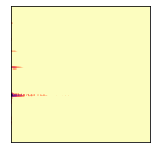

In [49]:
wav_name= 'Hp-ord-D3-ff.wav'
hp_dir= 'Hp-ord'
wav_path= os.path.join(data_dir, hp_dir, wav_name)

wav_raw, sr= librosa.core.load(wav_path, sr=None)
# wav_trim,_= librosa.effects.trim(y=wav_raw)
# wav_trim= np.roll(wav_raw, shift=0)

# Compute spectrogram

scalogram= librosa.core.cqt(y=wav_trim, 
                            bins_per_octave=24, 
                            hop_length=512, 
                            n_bins=24*7, 
                            sr=sr, 
                            sparsity=1e-7)
scalogram= np.abs(scalogram)**2

plt.figure(figsize=(2.5,2.5))
librosa.display.specshow(librosa.amplitude_to_db(scalogram), cmap='magma_r')
plt.ylim((50,167))
plt.xlim((0,500))
# plt.clim(0,1)
# plt.colorbar()

### Trumpet data matrix

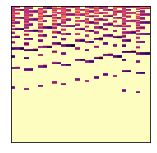

In [45]:
batch_str=['TpC','ff']

data_keys=[]
features_keys= features_dict.keys()
for key in features_dict.keys():
    if all(x in key for x in batch_str):
        data_keys.append(key)

# list(sorted(tpc_keys, key= lambda x: x.strip('#')))
data_keys=sorted(data_keys)

data_mat= []
for key in data_keys:
    data_mat.append(features_dict[key])

data_mat= np.stack(data_mat, axis=1)

from librosa import cqt_frequencies
from librosa.core import note_to_hz
freqs=cqt_frequencies(n_bins=24*3,bins_per_octave=24,fmin=note_to_hz('C1'))

plt.figure(figsize=(2.5,2.5))
specshow(librosa.amplitude_to_db(data_mat), cmap='magma_r')

### Harp data matrix

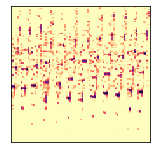

In [46]:
batch_str=['Hp','ff']

data_keys=[]
features_keys= features_dict.keys()
for key in features_dict.keys():
    if all(x in key for x in batch_str):
        data_keys.append(key)

# list(sorted(tpc_keys, key= lambda x: x.strip('#')))
data_keys=sorted(data_keys)

data_mat= []
for key in data_keys:
    data_mat.append(features_dict[key])

data_mat= np.stack(data_mat, axis=1)

from librosa import cqt_frequencies
from librosa.core import note_to_hz
freqs=cqt_frequencies(n_bins=24*3,bins_per_octave=24,fmin=note_to_hz('C1'))

plt.figure(figsize=(2.5,2.5))
specshow(librosa.amplitude_to_db(data_mat), cmap='magma_r')